In [1]:
# Ford 사에서 실제로 자동차 생산할때 엔진을 제작.... 이때 발생하는 진동수를 이용해서 문제점을 찾아 개선... 머신러닝
# 엔진의(정상/ 비정상)상태와 연관이 있을 수 있는 주변의 500개의 센서들로 측정

#목표 : 여러개의 계측센서가 시간순서대로 측정한 값으로 이루어진 시계열 데이터를 가지고 설비이 정상/비정상을 판단하는 분류 문제

#전략 : 도메인 지식(데이터에 대한 지식.)에 기반한 변수 선택 및 추출과정(Feature Selection / Engineering)없이 딥러닝 모델을 활용하여
       # 모델이 직접 모니터링 센서 간의 관계성이나 로컬한 특징과 같은 데이터에 내재된 특징을 직접추출하고 이를 통해 분류할수 있는 
       # 분석 프레임워크를 구축한다.
        
# 데이터 수집 방법 : Ford Classification Challenge에 제공한 오픈데이터

# 데이터셋 구조 :  총 4,921개의 시계열 구조, 학습용(Training) 3,601개 , 테스트용(Test)1,320개로 구성

# 독립변수/종속변수 정의  (표로 구성)
#  독립변수 : sensor 1~500번
# 종속변수 : 정상/비정상 class(총 1개)

# 데이터셋 선정이유 :
# 분석모델 소개
  # 지도학습(Supervised Leaning)기반의 알고리즘
  # 지도학습 기반으로 한 분류 알고리즘을 이용하여 문제를 해결하고자한다.
  # 분류를 이용하여 문제를 해결하고자 하는 경우, 입력에 대해 정상(1)일 확율과 비정상(-1)일 확율을 계산하여 확율이 높은 class로
  # 예측하는 과정이다.
  # 지도학습은 분류와 회귀가 대표적인데.. 분류와 회귀의 차이점은 다음과 같다.
   # ------ --- --
  # 지도학습   표나 그림으로 대체
    # 분류  회귀    
    # Linear Model, Ensemble, Neural Network
    # 각각에 대해 설명

In [2]:
save_file = './save/'  #저장 경로
file_path = './Data/'  #데이터 경로
train_fn = 'FordA_TRAIN.arff'  # train data
test_fn = 'FordA_TEST.arff'    # target data

In [6]:
# 라이브러리 로드
import itertools
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff
from sklearn.preprocessing import StandardScaler, RobustScaler
import tensorflow as tf
import os

In [33]:
# ariff 확장자를 가진 데이터를 load 하는 함수
def read_ariff(path):
    row_data,meta =  loadarff(path)
    cols = [x for x in meta]
    data2d = np.zeros([row_data.shape[0],len(cols)])
    for i, col in zip(range(len(cols)),cols):
        data2d[:,i] = row_data[col]
    return data2d

In [34]:
train = read_ariff(file_path+train_fn)
target = read_ariff(file_path+test_fn)
print(f"train data sets shape : {train.shape}")
print(f"target data sets shape : {target.shape}")

train data sets shape : (3601, 501)
target data sets shape : (1320, 501)


In [44]:
x_train =  train[:,:-1]
y_train = train[:,-1]
x_target = target[:,:-1]
y_target = target[:,-1]
x_train.shape, y_train.shape, x_target.shape, y_target.shape

((3601, 500), (3601,), (1320, 500), (1320,))

In [52]:
# 정상데이터와 비정상데이터 구분( 1 / -1)
normal_x = x_train[y_train == 1]  # x_train의 정상 데이터
abnormal_x = x_train[y_train == -1]  # x_train의 정상 데이터

normal_y = y_train[y_train == 1]  # y_train의 정상 데이터
abnormal_y = y_train[y_train == -1]  # y_train의 정상 데이터

normal_x.shape, abnormal_x.shape, normal_y.shape, abnormal_y.shape

((1755, 500), (1846, 500), (1755,), (1846,))

In [51]:
# x_train 을 8:2로 분리
# y_train  을 8:2로 분리
ind_x_normal =  int(normal_x.shape[0]*0.8)
ind_y_normal =  int(normal_y.shape[0]*0.8)
ind_x_abnormal =  int(abnormal_x.shape[0]*0.8)
ind_y_abnormal =  int(abnormal_y.shape[0]*0.8)

In [58]:
x_train = np.concatenate( (normal_x[:ind_x_normal],abnormal_x[:ind_x_abnormal]), axis = 0)  # 세로로 합친다
x_valid = np.concatenate( (normal_x[ind_x_normal:],abnormal_x[ind_x_abnormal:]), axis = 0)  # 세로로 합친다
y_train = np.concatenate( (normal_y[:ind_y_normal],abnormal_y[:ind_y_abnormal]), axis = 0)  # 세로로 합친다
y_valid = np.concatenate( (normal_y[ind_y_normal:],abnormal_y[ind_y_abnormal:]), axis = 0)  # 세로로 합친다

In [60]:
print(f"x_train shape : {x_train.shape}")
print(f"x_valid shape : {x_valid.shape}")
print(f"y_train shape : {y_train.shape}")
print(f"y_valid shape : {y_valid.shape}")
print(f"x_target shape : {x_target.shape}")
print(f"y_target shape : {y_target.shape}")

x_train shape : (2880, 500)
x_valid shape : (721, 500)
y_train shape : (2880,)
y_valid shape : (721,)
x_target shape : (1320, 500)
y_target shape : (1320,)


# 데이터 시각화

In [68]:
# class의 종류 확인 : 정상 1, 비정상 -1
classes =  np.unique( np.concatenate( (y_train, y_target), axis=0))
x = np.arange(len(classes)) # plot의 x축의 개수 구하기
labels = ["Abnormal","Normal"]
# train 데이터의 정상/비정상 각 총 개수
values_train = [(y_train == i).sum()  for i in classes]
# test 데이터의 정상/비정상 각 총 개수
values_valid = [(y_valid == i).sum()  for i in classes]
values_test = [(y_target == i).sum()  for i in classes]

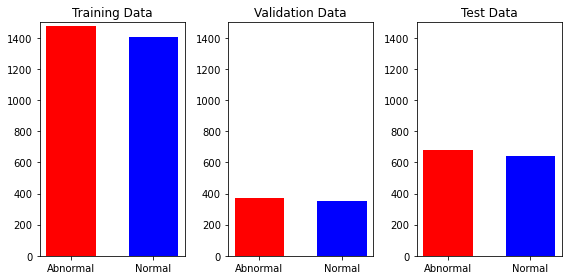

In [71]:
plt.figure(figsize=(8,4)) # size 설정
plt.subplot(1,3,1) # plot의 틀(figure) 의 3개의 subplot 중에 첫번째 지정
plt.title("Training Data")
plt.bar(x,values_train,width=0.6,color = ["red","blue"])
plt.ylim([0,1500])
plt.xticks(x,labels)

plt.subplot(1,3,2) # plot의 틀(figure) 의 3개의 subplot 중에 두번째 지정
plt.title("Validation Data")
plt.bar(x,values_valid,width=0.6,color = ["red","blue"])
plt.ylim([0,1500])
plt.xticks(x,labels)

plt.subplot(1,3,3) # plot의 틀(figure) 의 3개의 subplot 중에 두번째 지정
plt.title("Test Data")
plt.bar(x,values_test,width=0.6,color = ["red","blue"])
plt.ylim([0,1500])
plt.xticks(x,labels)

plt.tight_layout() # 그림저장
plt.savefig(save_file+"data_imbalance.png", dpi=100, bbox_inches='tight')
plt.show()

In [72]:
# 위의 데이터는 데이터 불균형..... 정상 비정상에 속한 데이터의 수가 차이가 클경우 분류가 제대로 되지 않을 가능성이 매우 높다
# 불균형 데이터를 확인해 보고, 불균형하다고 판단될 경우 추가작업이  필요
# 두 클래스에 속한 데이터의 수를 맞추는 방법 - Oversampling / underSampling  1:1맞춘다.... 여기서는 거의 비슷..

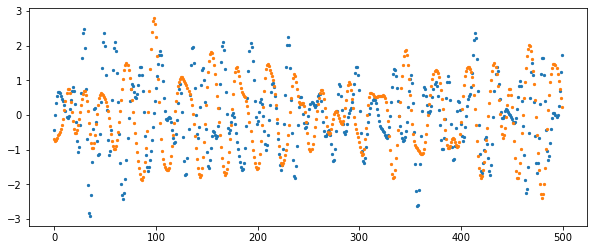

In [77]:
# 시계열데이터는 특정시간대에 플랏
import random
labels = np.unique(np.concatenate((y_train, y_target),axis=0))
plt.figure(figsize=(10,4))
for c in labels:
    c_x_train =  x_train[y_train == c]
    if c == -1 : c = 0  # 편의상 Abnormal case를 0으로 조정
    time_t = random.randint(0, c_x_train.shape[0]) # 0 ~ 0000 사이의 랜던한 정수가 특정 time t가 됨
    plt.scatter(range(0,500), c_x_train[time_t], label="class = " + str(int(c)), marker = 'o', s=5)